In [ ]:
#!pip install effdet
!pip install modin[ray]

In [1]:
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

Cloning into 'vision'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 8430 (delta 1), reused 6 (delta 0), pack-reused 8396
Receiving objects: 100% (8430/8430), 10.32 MiB | 4.81 MiB/s, done.
Resolving deltas: 100% (5782/5782), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
import sys
sys.path.append("vision/references/detection")
from pathlib import Path
path = Path.cwd()
input_dir = path.parent/"input/global-wheat-detection"
import cv2
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split, StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import wandb

# __print__ = print
# def print(string):
#     os.system(f'echo \"{string}\"')
#     __print__(string)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Configuration

In [2]:
train_dir = input_dir/'train'
test_dir = input_dir/'test'
cfg = {}

In [3]:
df = pd.read_csv(input_dir/'train.csv')
test_df = pd.read_csv(input_dir/"sample_submission.csv")

In [4]:
def get_bboxes_areas(row_box):
    bbox = np.fromstring(row_box[1:-1], sep=",")
    x, y, w, h = bbox
    return x, y, x+w, y+h, w*h


In [5]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1
df['area'] = 0
df[['xmin', 'ymin', 'xmax', 'ymax', 'area']] = np.stack(df['bbox'].apply(lambda row_box: get_bboxes_areas(row_box)))
df.drop(columns=["bbox"], inplace=True)
df.head()

,image_id,width,height,source,xmin,ymin,xmax,ymax,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0,2016.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,356.0,606.0,7540.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,451.0,664.0,11840.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,943.0,202.0,11663.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,150.0,261.0,14508.0


## EDA

## Stratified KFold Split Train, Val 

In [6]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
folds_df = df.groupby(["image_id", "source"])["source"].count().to_frame(name="bbox_count").reset_index()
folds_df['stratify_group'] = np.char.add(folds_df["source"].values.astype(str), folds_df['bbox_count'].apply(lambda x: f'_{x // 20}').values.astype(str))
folds_df['fold'] = 0
for fold, (train_index, test_index) in enumerate(skf.split(folds_df, folds_df.stratify_group)):
    folds_df.loc[test_index, 'fold'] = fold
folds_df.head()

CPU times: user 52.5 ms, sys: 3.85 ms, total: 56.4 ms
Wall time: 59.9 ms


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,image_id,source,bbox_count,stratify_group,fold
0,00333207f,arvalis_1,55,arvalis_1_2,4
1,005b0d8bb,usask_1,20,usask_1_1,4
2,006a994f7,inrae_1,25,inrae_1_1,2
3,00764ad5d,inrae_1,41,inrae_1_2,1
4,00b5fefed,arvalis_3,25,arvalis_3_1,0


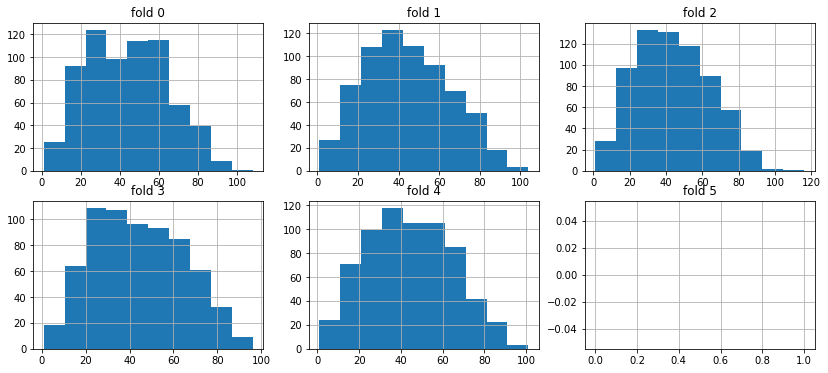

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.reshape(6)
for i, ax in enumerate(axes):
    folds_df.loc[folds_df.fold==i].bbox_count.hist(ax=ax) #axes[i // 2][i % 3])
    ax.set_title(f"fold {i}")
    

In [8]:
def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values


## DataSet

In [9]:
def show_boxes(image, target):
#     image, target = next(iter(dataset))
    image = image.permute(1, 2, 0).contiguous().numpy()
    boxes = target["boxes"].numpy().astype(int) # coco "boxes" pascal_voc bboxes
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for box in boxes:
        cv2.rectangle(image,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (200, 0, 0), 3)
    plt.imshow(image)

In [10]:
class GlobalWheatDataset(Dataset):
    def __init__(self, df, image_ids, data_dir, transforms, train=True):
        self.df = df
        self.image_ids = image_ids
        self.data_dir = data_dir
        self.transforms = transforms
        self.train = train
    
    def __len__(self,):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        filename = image_id + ".jpg"
        image_path = os.path.join(self.data_dir, filename)
        image = self.load_image(image_path)
        if self.train:
            bboxes_areas = self.df[self.df.image_id==image_id][["xmin", "ymin", "xmax", "ymax", "area"]].values#.astype(np.float)
            #bboxes_areas = torch.as_tensor(bboxes_areas, dtype=torch.float32)  
            bboxes = bboxes_areas[:, :-1]
            area = torch.as_tensor(bboxes_areas[:, -1])
            labels = torch.ones(len(bboxes), dtype=torch.int64)
            image_id = torch.as_tensor([index], dtype=torch.int64)
            iscrowd = torch.zeros(len(bboxes_areas), dtype=torch.uint8)
            
            target = {"boxes": bboxes,
                      "labels": labels,
                      "image_id": image_id,
                      "area": area,
                      "iscrowd": iscrowd,
                      }

            if self.transforms:
                sample = self.transforms(**{"image": image,
                                            "bboxes": bboxes,
                                            "labels": labels})
                
                target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32).reshape(-1, 4)
                image = sample["image"]
                return image, target
            else:
                return image, target
        else:
            sample = self.transforms(**{"image": image})
            return sample["image"], image_id
        
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = Image.open(image_path).convert("RGB")
        return image

class TestDataset(Dataset):
    def __init__(self, df, root_dir, transforms):
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms
    def __len__(self):
        return len(df)
    
    def __getitem__(self, index):
        image_id = self.df.loc[index, 'image_id']
        image_path = os.path.join(self.root_dir, image_id+".jpg")
        image = self.load(image_path)
        sample = self.transforms(**{"image": image})
        return sample["image"], image_id
    
    def load(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image

## Transofrms (Albumentations)

In [11]:
def get_train_transforms():
    return A.Compose(
        [
             A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),

            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_test_transforms():
    return A.Compose(
        [
#             A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
    )


def collate_fn(batch):
    sample = tuple(zip(*batch))
    return sample

## Data Loaders

In [12]:
train_transforms = get_train_transforms()
valid_transforms = get_valid_transforms()
test_transforms = get_test_transforms()

def get_train_val_indexes(df, fold):
    val_df = df.loc[df.fold==fold]
    train_df = df.loc[df.fold!=fold]
    return train_df.image_id.values, val_df.image_id.values

def get_train_valid_dataloaders(fold):
    train_idx, valid_idx = get_train_val_indexes(folds_df, fold)
    train_dataset = GlobalWheatDataset(df, train_idx, train_dir, train_transforms, train=True)
    valid_dataset = GlobalWheatDataset(df, valid_idx, train_dir, valid_transforms, train=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn)
    return train_dataloader, valid_dataloader

def get_test_dataloader():
    test_dataset = GlobalWheatDataset(test_df, test_df.image_id.unique(), test_dir, test_transforms, train=False)
    test_dataloader = DataLoader(test_dataset, batch_size=10, num_workers=4)
    return test_dataloader

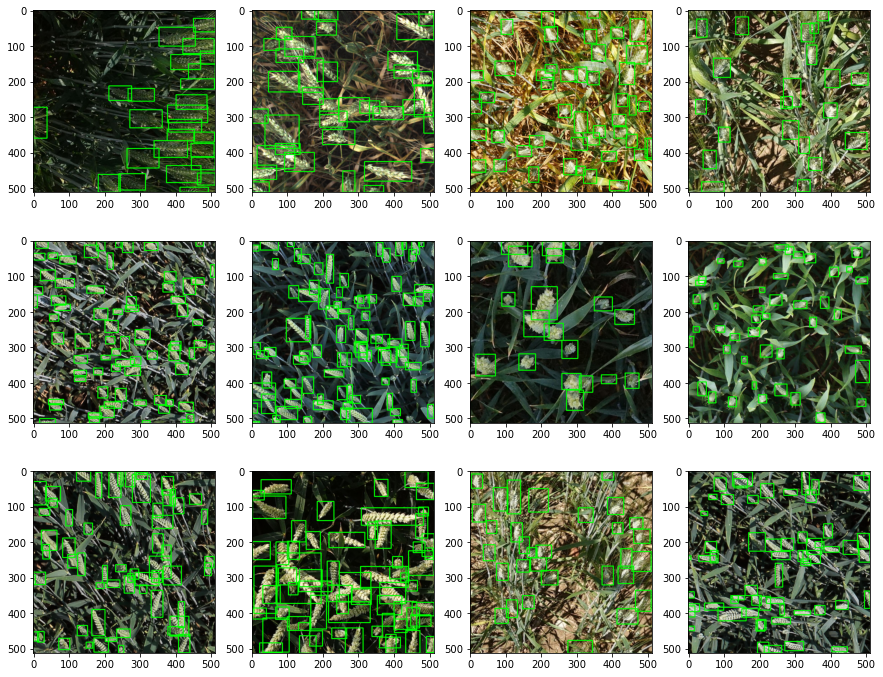

In [15]:
train_transforms = get_train_transforms()
image_ids = df.image_id.unique()
dataset = GlobalWheatDataset(df, image_ids, train_dir, train_transforms, train=True)
train_dataloader = DataLoader(dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.reshape(3*4)
train_dataloader, valid_dataloader = get_train_valid_dataloaders(0)
batch = next(iter(valid_dataloader))
for i ,ax in enumerate(axes):
    images, target = batch
    image = images[i].permute(1, 2, 0).contiguous().numpy()
    bboxes = target[i]["boxes"]
    for box in bboxes:
        box = np.array(box).astype(int)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    ax.imshow(image)
    

## Metric

## Model

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def load_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [14]:
def load_checkpoint(model, checkpoint_path='global_wheat_fasterrcnn_epoch_5.pth'):
    device = "cuda" if torch.cuda.is_available() else torch.device("cpu")
    checkpoint_path = path.parent/"input/checkpoint2/global_wheat_fasterrcnn_epoch_5.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)
    return model


## Criterion and Optimizer

In [15]:
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


In [16]:
import sys
import math
model = load_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## Trainin Loop

In [20]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    total_loss = 0
    print(header)
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            #print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += loss_value/len(data_loader)

        if lr_scheduler is not None:
            lr_scheduler.step()
        print(f"Train iteration: [{i}/{len(data_loader)}]\r", end="")
        #metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        #metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    print()
    print(f"Train Loss: {total_loss}")

In [21]:


def evaluation_loop(model, criterion, valid_dataloader, metric):
    model.eval()
    total_preds = []
    total_target = []
    total_loss = []
    
    for i, (images, targets) in enumerate(valid_dataloader):
        images = list(image.to(device) for image in images)
        total_target.append(targets)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        # images = images.to(device)
        loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(l for l in loss_dict.values())
        
        total_loss.append(loss)
        total_pred.append(preds)
    
    evaluation_loss = sum(total_loss)/len(total_loss)
    evaluation_score = metric(total_preds, total_targets)
    return evaluation_loss, evaluation_score

## Experiment

In [22]:
model = load_model()
model.to(device)
model = load_checkpoint(model)

nFolds = 5
nEpoch = 1
for fold in range(nFolds):
    train_dataloader, valid_dataloader = get_train_valid_dataloaders(fold)
    # define model, optimizer, lr_scheduler
    print(f"Fold: [{fold}/{nFolds}]")
    
    for epoch in range(nEpoch):
        train_one_epoch(model, optimizer, train_dataloader, device, epoch, 2)
        #evaluate(model, criterion, valid_loader, device, epoch, )
        evaluate(model, valid_dataloader, device=device)
    checkpoint_ref = "gwd_fasterrcnn_restnet50_fold_{fold}.pth"
    torch.save(model.state_dict(),checkpoint_ref)

Fold: [0/5]
Epoch: [0]


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Train iteration: [167/168]
Train Loss: 1.122511896349135
Fold: [1/5]
Epoch: [0]
Train iteration: [167/168]
Train Loss: 1.1145575262960936
Fold: [2/5]
Epoch: [0]
Train iteration: [167/168]
Train Loss: 1.133868007787636
Fold: [3/5]
Epoch: [0]
Train iteration: [167/168]
Train Loss: 1.1155846608536581
Fold: [4/5]
Epoch: [0]
Train iteration: [167/168]
Train Loss: 1.1187049945195506


## Inference

In [17]:
def inference(fold):
    test_loader = get_test_dataloader()
    image, target= next(iter(test_loader))
    model = load_model()
    model.to(device)
    model = load_checkpoint(model)
    image = image.to(device)
    model.eval()
    predictions = model(image)
    return predictions
    

In [76]:
#predictions = inference(0)
image_ids = []
predictSring = []
nboxes = 0
added_boxes = 0
for i, pred in enumerate(predictions):
        boxes = pred["boxes"].tolist()
        scores = pred["scores"].tolist()
        image_ids.append(target[i])
        pred_list = []
        nboxes += len(scores)
        for box, score in zip(boxes, scores):
            if score > 0.5:
                pred_list.extend([score])
                pred_list.extend(box)
                added_boxes += 1
        
        predictionString = " ".join([str(i) for i in pred_list])
        predictSring.append(predictionString)
        #print(predictionString)
        
        

In [77]:
nboxes, added_boxes

(495, 238)

In [79]:
submission = pd.DataFrame()
submission["image_id"] = target
submission["PredictionString"] = predictSring


In [61]:
[1, 2, 3].

AttributeError: 'list' object has no attribute 'items'

In [52]:
d = {"0": "hello", "1":"sami"}
dff = pd.DataFrame.from_dict(d, orient="index", columns=['value'])
dff.head()

,value
0,hello
1,sami


In [26]:
images = images.to(device)
model.eval()
predictions = model(images)

In [28]:
def show_prediction(idx, thresh):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    boxes = predictions[idx]["boxes"]
    scores = predictions[idx]["scores"]
    image = cv2.imread(os.path.join(test_dir, image_ids[idx]+".jpg"), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    #image = cv2.resize(image, (512, 512))
    for i, box in enumerate(boxes):
        score = scores[i]
        if score>thresh:
            score_text = f"{scores[i]*100:.2f}%"
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            cv2.putText(image, score_text, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,42), 2)
    ax.imshow(image)

(1024, 1024, 3)


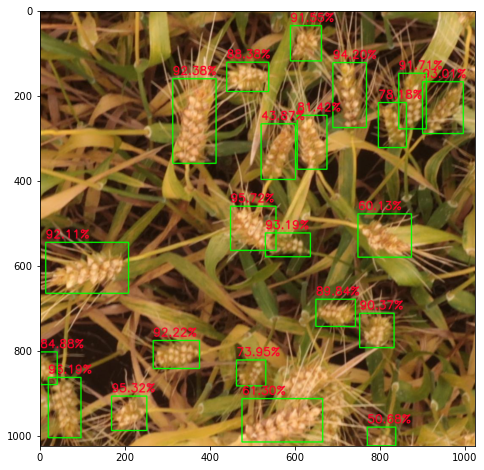

In [33]:
show_prediction(8, thresh=0.4)